In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import OrderedDict
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper, NonparametricIV

In [5]:
# 0. random data.  price is endogenous, instrument is this 
n = 30000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

test_cutoff = int(2/3*df.shape[0])
df_train = df.iloc[:test_cutoff,:]
df_test = df.iloc[test_cutoff:,:]

In [6]:
df.head()

,x_0,x_1,unobserved_elast,unobserved_log_cost,unobserved_log_optimal_price,instrument,log_price,log_sales,id
0,-1.085631,0.997345,-5.655537,-0.062427,0.132151,-0.020052,0.112099,0.652629,0
1,0.282978,-1.506295,-3.509918,-0.865015,-0.529673,-0.019894,-0.549566,0.428899,1
2,-0.578600,1.651437,-6.767036,0.758610,0.918515,-0.071540,0.846975,-4.420754,2
3,-2.426679,-0.428913,-6.482309,-2.019208,-1.851658,-0.063908,-1.915566,8.493125,3
4,1.265936,-0.866740,-2.470734,0.282274,0.801028,0.017801,0.818829,-1.016895,4


### 0. initialize models

In [7]:
# initialize a nonparametric IV model that estimates quantiles in the first stage and uses a linear
#  specification in the second stage
npiv_estimate_stage1_linear_stage2 = NonparametricIV(df=df_train,
                                                     exog_x_cols=ivsim.exog_x_cols, 
                                                     instrument_cols = ['instrument'],
                                                     endog_x_col=ivsim.endog_x_col,
                                                     y_col=ivsim.y_col,
                                                     id_col='id')

In [9]:
# initialize a nonparametric IV model that uses true quantiles in the first stage
# first, need a class for the model that produces the true quantiles
class TrueQtlModel:
    elast_max = ivsim.elast_max
    elast_min = ivsim.elast_min
    log_cost_coefs = ivsim.log_cost_coefs
    exog_x_cols = ivsim.exog_x_cols
    instrument_col = ivsim.instrument_col
    def __init__(self, alpha):
        self.alpha=alpha
    def feature_name(self):
        return self.exog_x_cols+[self.instrument_col]
    def predict(self, df):
        elast_qtl = self.alpha * (self.elast_max - self.elast_min) + self.elast_min 
        log_costs = iv_simulator.generate_log_costs(df[self.exog_x_cols], self.log_cost_coefs)
        log_price_qtl = iv_simulator.generate_log_optimal_prices(log_costs, elast_qtl) + df[self.instrument_col]
        return log_price_qtl
# now, we can construct the dict models for passing into NonparametricIV
# use the same quantiles as the model where we estimate stage1
qtl_list = list(npiv_estimate_stage1_linear_stage2.stage1_params.keys())
print(qtl_list)
stage1_models = {alpha : TrueQtlModel(alpha) for alpha in qtl_list}
# finally, init the npiv model
npiv_true_stage1_linear_stage2 = NonparametricIV(df=df_train,
                                                 exog_x_cols=ivsim.exog_x_cols, 
                                                 instrument_cols = ['instrument'],
                                                 endog_x_col=ivsim.endog_x_col,
                                                 y_col=ivsim.y_col,
                                                 stage1_models=stage1_models,
                                                 id_col='id')

[0.050000000000000003, 0.15000000000000002, 0.25, 0.35000000000000003, 0.45000000000000001, 0.55000000000000004, 0.65000000000000013, 0.75000000000000011, 0.85000000000000009, 0.95000000000000007]


### 1. stage 1 : quantiles

In [10]:
# train the stage1 models for the model that requires training
npiv_estimate_stage1_linear_stage2.train_stage1()

alpha=0.05
Training until validation scores don't improve for 100 rounds.
[100]	train's quantile: 0.0237417	val's quantile: 0.0250463
[200]	train's quantile: 0.016119	val's quantile: 0.0169271
[300]	train's quantile: 0.0140731	val's quantile: 0.0150263
[400]	train's quantile: 0.013228	val's quantile: 0.0142396


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:112: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[500]	train's quantile: 0.0128799	val's quantile: 0.0139559
[600]	train's quantile: 0.012727	val's quantile: 0.0138765
[700]	train's quantile: 0.0126374	val's quantile: 0.0138103
[800]	train's quantile: 0.012566	val's quantile: 0.013762
[900]	train's quantile: 0.0125053	val's quantile: 0.013745
[1000]	train's quantile: 0.0124643	val's quantile: 0.0137248
Did not meet early stopping. Best iteration is:
[1000]	train's quantile: 0.0124643	val's quantile: 0.0137248
alpha=0.15000000000000002
Training until validation scores don't improve for 100 rounds.
[100]	train's quantile: 0.0479856	val's quantile: 0.0499071
[200]	train's quantile: 0.0378785	val's quantile: 0.0396061
[300]	train's quantile: 0.0362211	val's quantile: 0.037951
[400]	train's quantile: 0.0357825	val's quantile: 0.0376016
[500]	train's quantile: 0.0355608	val's quantile: 0.0374879
[600]	train's quantile: 0.0354468	val's quantile: 0.0374357
[700]	train's quantile: 0.0353631	val's quantile: 0.0373896
[800]	train's quantile: 0.

In [11]:
# compare the predicted vs true quantiles
qtl_comp_df = pd.concat([
                            npiv_estimate_stage1_linear_stage2.predict_stage1(df_test, prefix='predicted_qtl'),
                            npiv_true_stage1_linear_stage2.predict_stage1(df_test, prefix='true_qtl')
                        ], axis=1)


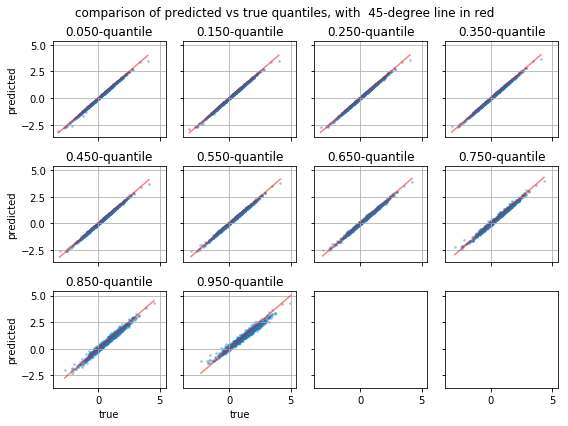

In [12]:
# look at quantiles
plot_df = qtl_comp_df.sample(1000)
alphas = npiv_estimate_stage1_linear_stage2.stage1_params.keys()
ncols=4
nrows = int(np.ceil(len(alphas)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows), 
                         sharex=True, sharey=True)
for i,alpha in enumerate(alphas):
    ax = axes[i//ncols][i%ncols]
    true_col = 'true_qtl_{:.3f}'.format(alpha)
    pred_col = 'predicted_qtl_{:.3f}'.format(alpha)
    tmp_df = plot_df[[true_col, pred_col]].rename(columns={true_col:'true', pred_col:'predicted'})
    tmp_df.plot(x='true', y = 'predicted', ax=ax, kind='scatter',
                 alpha=.3, s=3, title="{:.3f}-quantile".format(alpha), grid=True)
    # also plot the 45-degree line
    min45, max45 = tmp_df['true'].min(), tmp_df['true'].max()
    ax.plot([min45, max45], [min45, max45], color='red', alpha=.5)
plt.suptitle("comparison of predicted vs true quantiles, with  45-degree line in red")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [ ]:
# ok, quantiles look fine.

### 2. stage2 : nonparametric IV

In [ ]:
assert False

In [ ]:
df.head()

In [ ]:
df['log_price'].iloc[:10]

In [ ]:
np.repeat('jacob', 3)

In [ ]:
np.concatenate([np.repeat('jacob', 3), np.repeat('haitao', 4)])

In [ ]:
gbm = npiv_model.stage1_models[.05]

In [ ]:
npiv_model.stage1_params

In [ ]:
npiv_model.stage1_models[.05].eval_results['val']['quantile']

In [ ]:
df.columns